<a href="https://colab.research.google.com/github/Abhilash-Bee/DeepLearningCertification/blob/main/09_Milestone_Project_2_SkimLit_%F0%9F%93%84%F0%9F%94%A5_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🛠 09. Milestone Project 2: SkimLit 📄🔥 Exercises**

1. Train `model_5` on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
  * [`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) to save the model's best weights only.
  * [`tf.keras.callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop the model from training once the validation loss has stopped improving for ~3 epochs.
2. Checkout the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/). Can you get this working with one of our models?
  * Hint: You'll want to incorporate it with a custom token [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.
  * It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.
3. Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained  embedding for the [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
  * Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the [TensorFlow Hub guide](https://tfhub.dev/google/experts/bert/pubmed/2)).
  * Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf
4. What happens if you were to merge our `line_number` and `total_lines` features for each sequence? For example, created a `X_of_Y` feature instead? Does this effect model performance?
  * Another example: `line_number=1` and `total_lines=11` turns into `line_of_X=1_of_11`.
5. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:
  * `PREDICTED_LABEL`: `SEQUENCE`
  * `PREDICTED_LABEL`: `SEQUENCE`
  * `PREDICTED_LABEL`: `SEQUENCE`
  * `PREDICTED_LABEL`: `SEQUENCE`
  * ...
    * You can find your own unstructured RCT abstract from PubMed or try this one from: [*Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection*](https://pubmed.ncbi.nlm.nih.gov/22244707/).

---
---

## **Importing dependencies**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import os

## **Getting the data**

In [ ]:
!wget https://raw.githubusercontent.com/Abhilash-Bee/DeepLearningCertification/main/extras/helper_function.py

from helper_function import *

--2024-02-12 12:29:54--  https://raw.githubusercontent.com/Abhilash-Bee/DeepLearningCertification/main/extras/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8079 (7.9K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]   7.89K  --.-KB/s    in 0s      

2024-02-12 12:29:54 (60.0 MB/s) - ‘helper_function.py’ saved [8079/8079]



In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 27.21 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
os.listdir(data_dir)

['test.txt', 'dev.txt', 'train.txt']

In [ ]:
files = tuple([data_dir + filename for filename in os.listdir(data_dir)])
files

('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')

In [ ]:
test_file, val_file, train_file = files

val_file, train_file, test_file

('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

## **Functions to preprocess the data**

In [ ]:
def txt_file_to_list(filename):
  """
  Gets the data in text file in form of list of lines.

  Args:
    filename - .txt file

  Returns:
    list of lines in the text file
  """

  with open(filename, 'r') as f:
    data = f.readlines()

  return data

In [ ]:
def list_to_dict(data_list: list, list_dict: list) -> list:
  """

  """

  length = len(data_list) - 1

  for i in range(len(data_list)):
    data = tuple(data_list[i].replace('\n', '').split('\t'))
    if data[0] != '':
      list_dict.append({
          'line_number': i,
          'target': data[0],
          'text': data[1],
          'total_lines': length,
      })

  return list_dict

In [ ]:
def abstract_txt_file_of_sentences_to_dict(filename):
  """

  """

  list_dict = []

  data = txt_file_to_list(filename)

  start, end = 1, len(data)

  data_list = []
  for i in range(len(data)):
    if i == end - 1:
      list_dict = list_to_dict(data[start:end], list_dict)

    elif data[i] == '\n':
      end = i
      list_dict = list_to_dict(data[start:end], list_dict)
      start = i + 2

  return list_dict

In [ ]:
%%time
train_data_dict = abstract_txt_file_of_sentences_to_dict(train_file)
test_data_dict = abstract_txt_file_of_sentences_to_dict(test_file)
val_data_dict = abstract_txt_file_of_sentences_to_dict(val_file)

CPU times: user 326 ms, sys: 57 ms, total: 383 ms
Wall time: 506 ms


In [ ]:
train_data_dict[:2], len(train_data_dict)

([{'line_number': 0,
   'target': 'OBJECTIVE',
   'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
   'total_lines': 11},
  {'line_number': 1,
   'target': 'METHODS',
   'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
   'total_lines': 11}],
 180040)

In [ ]:
test_data_dict[:2], len(test_data_dict)

([{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
   'total_lines': 8},
  {'line_number': 1,
   'target': 'RESULTS',
   'text': 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
   'total_lines': 8}],
 30135)

In [ ]:
val_data_dict[:2], len(val_data_dict)

([{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
   'total_lines': 9},
  {'line_number': 1,
   'target': 'BACKGROUND',
   'text': 'It is not clear whether these patients would benefit from antifungal treatment .',
   'total_lines': 9}],
 30212)

In [ ]:
train_df = pd.DataFrame(train_data_dict)
test_df = pd.DataFrame(test_data_dict)
val_df = pd.DataFrame(val_data_dict)

In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11


In [ ]:
test_df.head()

,line_number,target,text,total_lines
0,0,BACKGROUND,This study analyzed liver function abnormaliti...,8
1,1,RESULTS,A post hoc analysis was conducted with the use...,8
2,2,RESULTS,Liver function tests ( LFTs ) were measured at...,8
3,3,RESULTS,Survival analyses were used to assess the asso...,8
4,4,RESULTS,The percentage of patients with abnormal LFTs ...,8


In [ ]:
val_df.head()

,line_number,target,text,total_lines
0,0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,9
1,1,BACKGROUND,It is not clear whether these patients would b...,9
2,2,OBJECTIVE,We sought to determine whether a @-month cours...,9
3,3,METHODS,Asthmatic patients who were IgE sensitized to ...,9
4,4,METHODS,Primary outcomes were improvement in quality o...,9


## **Convert the target label to one-hot-encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

train_df['target'] = encoder.fit_transform(train_df['target'])
test_df['target'] = encoder.transform(test_df['target'])
val_df['target'] = encoder.transform(val_df['target'])

In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,3,To investigate the efficacy of @ weeks of dail...,11
1,1,2,A total of @ patients with primary knee OA wer...,11
2,2,2,Outcome measures included pain reduction and i...,11
3,3,2,Pain was assessed using the visual analog pain...,11
4,4,2,Secondary outcome measures included the Wester...,11


In [ ]:
test_df.head()

,line_number,target,text,total_lines
0,0,0,This study analyzed liver function abnormaliti...,8
1,1,4,A post hoc analysis was conducted with the use...,8
2,2,4,Liver function tests ( LFTs ) were measured at...,8
3,3,4,Survival analyses were used to assess the asso...,8
4,4,4,The percentage of patients with abnormal LFTs ...,8


In [ ]:
val_df.head()

,line_number,target,text,total_lines
0,0,0,IgE sensitization to Aspergillus fumigatus and...,9
1,1,0,It is not clear whether these patients would b...,9
2,2,3,We sought to determine whether a @-month cours...,9
3,3,2,Asthmatic patients who were IgE sensitized to ...,9
4,4,2,Primary outcomes were improvement in quality o...,9


In [ ]:
len(train_df['target'].unique())

5

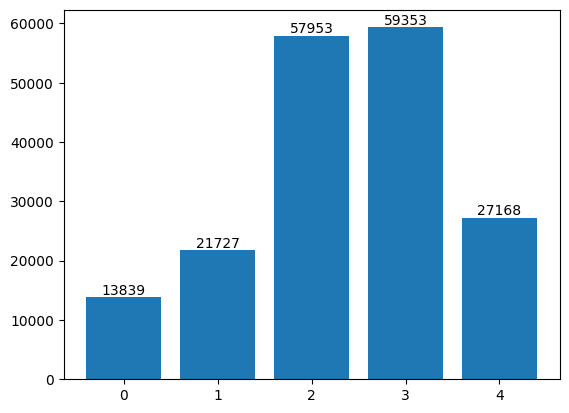

In [ ]:
fig, ax = plt.subplots()
ax.bar(train_df['target'].unique(), train_df['target'].value_counts())
ax.bar_label(ax.containers[0]);

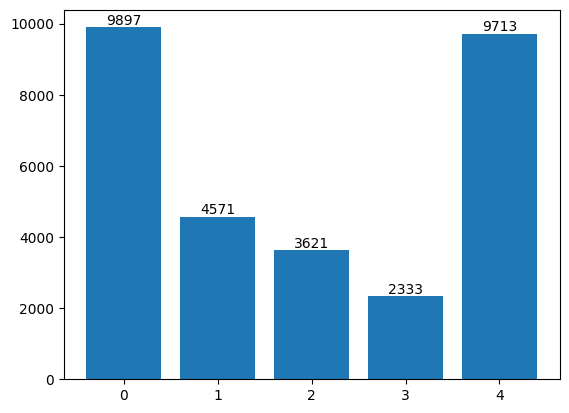

In [ ]:
fig, ax = plt.subplots()
ax.bar(test_df['target'].unique(), test_df['target'].value_counts())
ax.bar_label(ax.containers[0]);

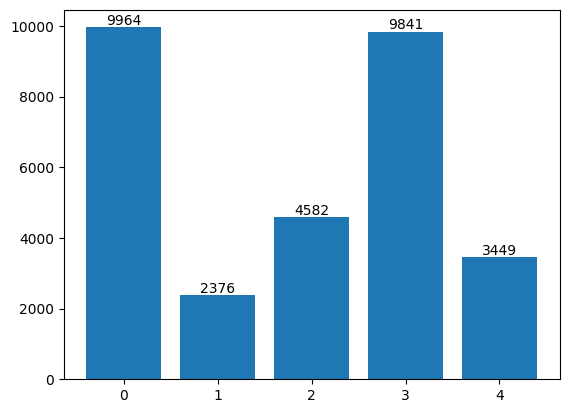

In [ ]:
fig, ax = plt.subplots()
ax.bar(val_df['target'].unique(), val_df['target'].value_counts())
ax.bar_label(ax.containers[0]);

In [ ]:
train_target_one_hot = tf.one_hot(train_df['target'].to_list(), depth=5)
train_target_one_hot

<tf.Tensor: shape=(180040, 5), dtype=float32, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [ ]:
test_target_one_hot = tf.one_hot(test_df['target'].to_list(), depth=5)
test_target_one_hot

<tf.Tensor: shape=(30135, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [ ]:
val_target_one_hot = tf.one_hot(val_df['target'].to_list(), depth=5)
val_target_one_hot

<tf.Tensor: shape=(30212, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

## **Model - 0 (Baseline model with `TfidfVectorizer`)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_df['text'].to_list(), train_df['target'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
y_true = np.array(val_df['target'].to_list())
y_true[:5]

array([0, 0, 3, 2, 2])

In [ ]:
y_pred = model_0.predict(val_df['text'].to_list())
y_pred[:5]

array([4, 1, 3, 2, 2])

In [ ]:
base_model_results = calculate_results(y_true, y_pred)
base_model_results

{'Accuracy score': 0.7218323844829869,
 'Precision score': 0.7186466952323352,
 'Recall score': 0.7218323844829869,
 'F1 score': 0.6989250353450294}

## **Model - 1 (Convolutional 1D with Token embedding)**

### **Creating text vectorizer layer**

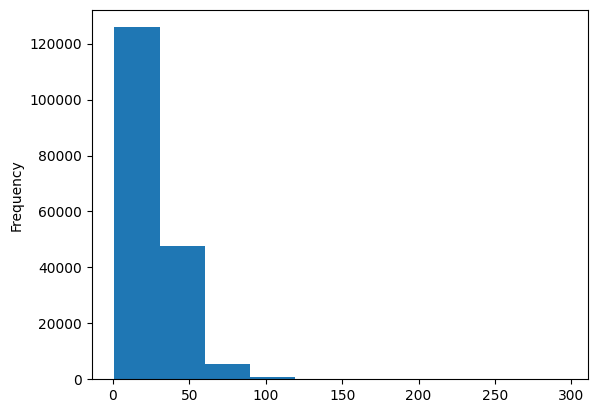

In [ ]:
sentence_lengths = [len(sentence.split()) for sentence in train_df['text'].to_list()]
pd.Series(sentence_lengths).plot(kind='hist');

In [ ]:
output_sequence_length = int(np.percentile(sentence_lengths, 95))
output_sequence_length

55

In [ ]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=68000, # From the paper, total vocabulary = 68k
                                                    output_sequence_length=output_sequence_length,
                                                    name='Text_vectorization')

text_vectorizer.adapt(train_df['text'].to_list())

In [ ]:
inverse_vocab = text_vectorizer.get_vocabulary()
vocab_size = len(inverse_vocab)
print(f'Top 5 max repeated words/Tokens in train data: {inverse_vocab[:5]}')
print(f'Top 5 least repeated words/Tokens in train data: {inverse_vocab[-5:]}')
print(f'Total vocabulary size: {vocab_size}')

Top 5 max repeated words/Tokens in train data: ['', '[UNK]', 'the', 'and', 'of']
Top 5 least repeated words/Tokens in train data: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']
Total vocabulary size: 64841


### **Create embedding layer**

In [ ]:
text_embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                           output_dim=256,
                                           name='Text_embedding')

In [ ]:
text_embedding(text_vectorizer(['This is so cool']))

<tf.Tensor: shape=(1, 55, 256), dtype=float32, numpy=
array([[[-0.04351018, -0.04031549,  0.02593322, ...,  0.0241649 ,
         -0.00111281, -0.02311157],
        [-0.01354084, -0.03855766,  0.0085332 , ...,  0.01188985,
          0.00031536, -0.00890751],
        [-0.0369289 , -0.00204165,  0.0308812 , ..., -0.03970599,
          0.01135714, -0.01237274],
        ...,
        [ 0.00539653,  0.04407105,  0.04870341, ..., -0.03016183,
          0.0053516 , -0.03298832],
        [ 0.00539653,  0.04407105,  0.04870341, ..., -0.03016183,
          0.0053516 , -0.03298832],
        [ 0.00539653,  0.04407105,  0.04870341, ..., -0.03016183,
          0.0053516 , -0.03298832]]], dtype=float32)>

In [ ]:
# Create the model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Input_layer')

vectorize = text_vectorizer(inputs)

embedding = text_embedding(vectorize)

conv1D_1 = tf.keras.layers.Conv1D(128, 5, activation='relu')(embedding)

drop = tf.keras.layers.Dropout(0.5)(conv1D_1)

conv1D_2 = tf.keras.layers.Conv1D(128, 5, activation='relu')(drop)

maxPool1D = tf.keras.layers.GlobalMaxPool1D()(conv1D_2)

outputs = tf.keras.layers.Dense(5, activation='softmax', name='Output_layer')(maxPool1D)

model_1 = tf.keras.Model(inputs, outputs, name='Model_1_conv1D')


# Compile the model
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                metrics=['accuracy'])

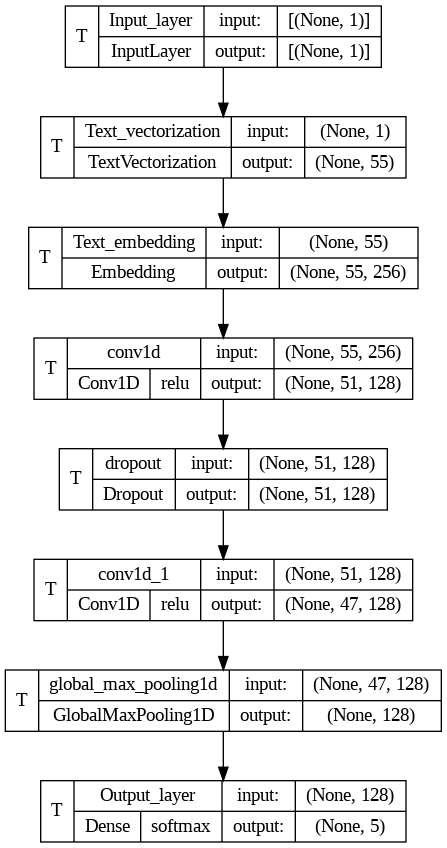

In [ ]:
tf.keras.utils.plot_model(model_1, show_layer_activations=True, show_trainable=True, show_shapes=True)

In [ ]:
# Create the dataset
train_token_dataset = tf.data.Dataset.from_tensor_slices((train_df['text'].to_list(), train_target_one_hot))
train_token_dataset = train_token_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

val_token_dataset = tf.data.Dataset.from_tensor_slices((val_df['text'].to_list(), val_target_one_hot))
val_token_dataset = val_token_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit the model
history_1 = model_1.fit(train_token_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.15 * len(train_token_dataset)),
                        validation_data=val_token_dataset,
                        validation_steps=int(0.15 * len(val_token_dataset)))

Epoch 1/5
70/70 [==============================] - 11s 90ms/step - loss: 1.4757 - accuracy: 0.4000 - val_loss: 1.2696 - val_accuracy: 0.5670
Epoch 2/5
70/70 [==============================] - 4s 63ms/step - loss: 1.1840 - accuracy: 0.6558 - val_loss: 1.1169 - val_accuracy: 0.7040
Epoch 3/5
70/70 [==============================] - 3s 42ms/step - loss: 1.1035 - accuracy: 0.7138 - val_loss: 1.0698 - val_accuracy: 0.7397
Epoch 4/5
70/70 [==============================] - 2s 34ms/step - loss: 1.0659 - accuracy: 0.7480 - val_loss: 1.0358 - val_accuracy: 0.7636
Epoch 5/5
70/70 [==============================] - 2s 25ms/step - loss: 1.0460 - accuracy: 0.7554 - val_loss: 1.0200 - val_accuracy: 0.7770


In [ ]:
y_prob = model_1.predict(val_token_dataset)
y_prob[:5]

471/471 [==============================] - 2s 3ms/step


array([[0.21831687, 0.17545384, 0.28637555, 0.22328709, 0.09656662],
       [0.03201243, 0.03658538, 0.8430158 , 0.03987485, 0.04851157],
       [0.03249319, 0.02980309, 0.7452409 , 0.04068001, 0.15178266],
       [0.03628542, 0.02771103, 0.8197361 , 0.04495789, 0.07130956],
       [0.04048212, 0.09910369, 0.06223497, 0.04599892, 0.7521803 ]],
      dtype=float32)

In [ ]:
y_pred = tf.argmax(y_prob, axis=1).numpy()
y_pred[:10]

array([2, 2, 2, 2, 4, 4, 4, 0, 1, 1])

In [ ]:
y_true[:10]

array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0])

In [ ]:
model_1_results = calculate_results(y_true, y_pred)
model_1_results

{'Accuracy score': 0.7744151319064211,
 'Precision score': 0.7695888178261899,
 'Recall score': 0.7744151319064211,
 'F1 score': 0.7712690222595211}

## **Model - 2 (using `Univeral Sentence Encoder` pretrained feature extraction)**

In [ ]:
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133018 -0.06338633 -0.016075   ... -0.03242778 -0.04575739
   0.05370454]
 [ 0.05080859 -0.01652432  0.01573777 ...  0.00976659  0.0317012
   0.01788118]], shape=(2, 512), dtype=float32)


In [ ]:
tf_hub_use_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                  trainable=False,
                                  name='Universal_Sentence_Encoder_layer')

In [ ]:
# Create the model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='Input_layer')

use = tf_hub_use_layer(inputs)

x = tf.keras.layers.Dense(128, activation='relu')(use)

outputs = tf.keras.layers.Dense(5, activation='softmax', name='Output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs, name='Model_2_USE_feature_extraction')


# Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                metrics=['accuracy'])

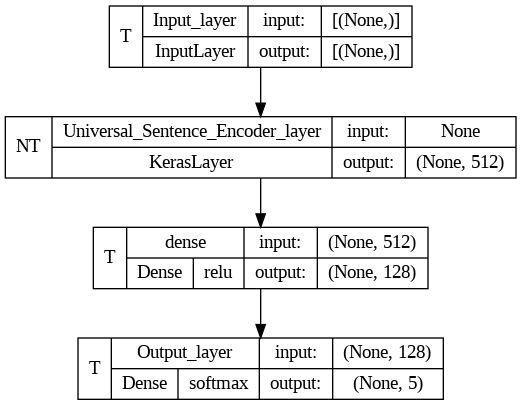

In [ ]:
tf.keras.utils.plot_model(model_2, show_shapes=True, show_trainable=True, show_layer_activations=True)

In [ ]:
# Fit the model
history_2 = model_2.fit(train_token_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.15 * len(train_token_dataset)),
                        validation_data=val_token_dataset,
                        validation_steps=int(0.15 * len(val_token_dataset)))

Epoch 1/5
70/70 [==============================] - 5s 31ms/step - loss: 1.3854 - accuracy: 0.5004 - val_loss: 1.2323 - val_accuracy: 0.6127
Epoch 2/5
70/70 [==============================] - 3s 37ms/step - loss: 1.1865 - accuracy: 0.6580 - val_loss: 1.1647 - val_accuracy: 0.6681
Epoch 3/5
70/70 [==============================] - 2s 25ms/step - loss: 1.1499 - accuracy: 0.6792 - val_loss: 1.1452 - val_accuracy: 0.6871
Epoch 4/5
70/70 [==============================] - 2s 32ms/step - loss: 1.1200 - accuracy: 0.7078 - val_loss: 1.1379 - val_accuracy: 0.6848
Epoch 5/5
70/70 [==============================] - 2s 27ms/step - loss: 1.1249 - accuracy: 0.6953 - val_loss: 1.1262 - val_accuracy: 0.6980


In [ ]:
y_prob = model_2.predict(val_token_dataset)
y_prob[:2]

471/471 [==============================] - 9s 18ms/step


array([[0.40448624, 0.15384722, 0.09812525, 0.24710323, 0.09643795],
       [0.23475286, 0.11706052, 0.2308993 , 0.35543442, 0.0618529 ]],
      dtype=float32)

In [ ]:
y_pred = tf.argmax(y_prob, axis=1).numpy()
y_pred[:10]

array([0, 3, 2, 2, 4, 4, 2, 2, 4, 1])

In [ ]:
y_true[:10]

array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0])

In [ ]:
# Getting the results
model_2_results = calculate_results(y_true, y_pred)
model_2_results

{'Accuracy score': 0.698755599800896,
 'Precision score': 0.6912564186355645,
 'Recall score': 0.698755599800896,
 'F1 score': 0.6914293465473289}

## 3. Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained  embedding for the [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
  * Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the [TensorFlow Hub guide](https://tfhub.dev/google/experts/bert/pubmed/2)).
  * Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf

In [ ]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.3 MB/s eta 0:00:00


In [ ]:
import tensorflow_text as text

preprocessing_layer = hub.KerasLayer('https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3',
                                     trainable=False,
                                     name='Pubmed_preprocessing')

bert_layer = hub.KerasLayer('https://www.kaggle.com/models/google/experts-bert/frameworks/TensorFlow2/variations/pubmed/versions/2',
                            trainable=False,
                            name='Pubmed_bert')

In [ ]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

In [ ]:
train_sentences[0]

'IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .'

In [ ]:
preprocess = preprocessing_layer([train_sentences[0]])
preprocess['input_word_ids']

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  1045,  3351, 12411, 28032,  3989,  2000,  2004,  4842,
        19791,  2271, 11865,  4328, 20697,  2271,  1998,  1037,  3893,
        11867,  4904,  2819, 28079,  3226,  2765,  2024,  2691,  1999,
         5022,  2007, 25416, 22648,  7062, 26180,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [ ]:
bert_output = bert_layer(preprocess)
bert_output['sequence_output']

<tf.Tensor: shape=(1, 128, 768), dtype=float32, numpy=
array([[[ 0.21576953, -0.56392694,  0.5721406 , ..., -0.19578788,
         -0.5291119 ,  0.00563973],
        [ 0.66371775,  1.0057389 ,  0.21314916, ..., -0.16947345,
         -0.64909756, -0.20196834],
        [ 0.36947703,  0.40794635,  0.59264666, ..., -0.30858442,
          0.40313023,  2.7297702 ],
        ...,
        [ 0.31905347, -0.04920682, -0.11775312, ..., -0.176391  ,
          0.05770683,  1.870707  ],
        [ 0.14673187, -0.10691833,  0.20973733, ..., -0.29968703,
          0.00699753,  0.8586613 ],
        [-0.1031664 , -0.19521117,  0.7128737 , ..., -0.20712855,
         -0.29849944, -1.6214525 ]]], dtype=float32)>

In [ ]:
# Pubmed model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='Input_layer')

preprocess = preprocessing_layer(inputs)

bert = bert_layer(preprocess)['sequence_output']

dense = tf.keras.layers.Dense(256, activation='relu')(bert)

maxpool = tf.keras.layers.GlobalMaxPooling1D()(dense)

outputs = tf.keras.layers.Dense(5, activation='softmax')(maxpool)

pubmed_model = tf.keras.Model(inputs, outputs, name='Pubmed_model')


# Compile the model
pubmed_model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                     metrics=['accuracy'])

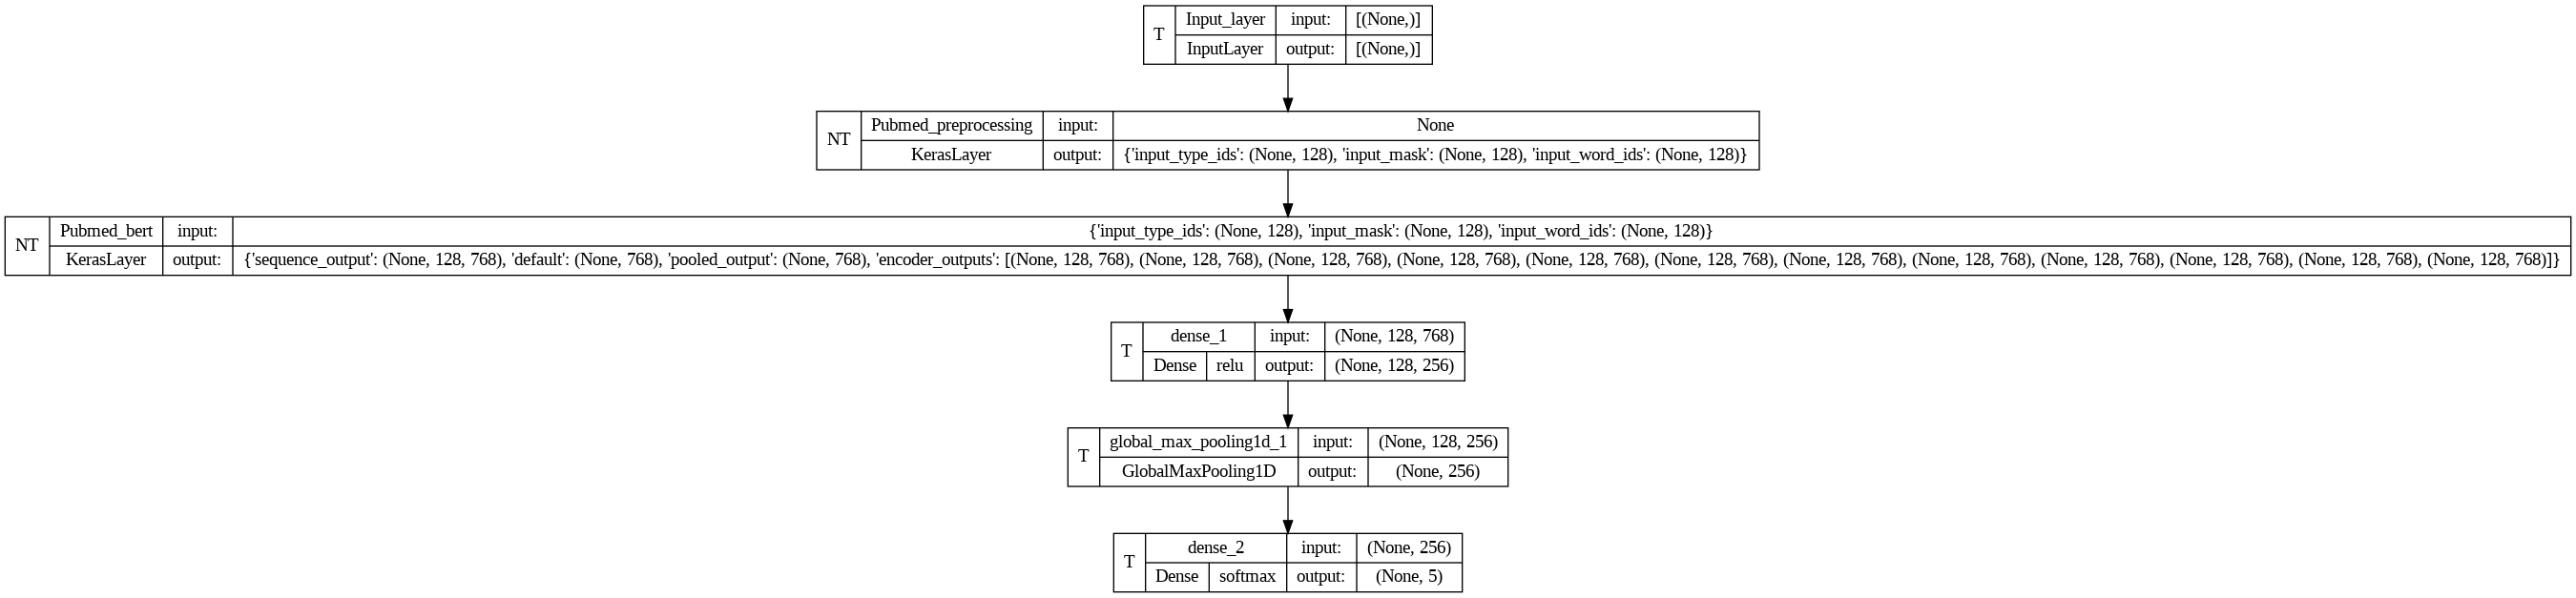

In [ ]:
tf.keras.utils.plot_model(pubmed_model, show_shapes=True, show_trainable=True, show_layer_activations=True)

In [ ]:
# Fit the model
history_pubmed = pubmed_model.fit(train_token_dataset,
                                  epochs=5,
                                  steps_per_epoch=int(0.15 * len(train_token_dataset)),
                                  validation_data=val_token_dataset,
                                  validation_steps=int(0.15 * len(val_token_dataset)))

Epoch 1/5
422/422 [==============================] - 383s 888ms/step - loss: 1.0470 - accuracy: 0.8035 - val_loss: 1.0427 - val_accuracy: 0.8232
Epoch 2/5
422/422 [==============================] - 343s 812ms/step - loss: 0.9767 - accuracy: 0.8390 - val_loss: 0.9427 - val_accuracy: 0.8388
Epoch 3/5
422/422 [==============================] - 376s 891ms/step - loss: 0.9459 - accuracy: 0.8503 - val_loss: 0.8961 - val_accuracy: 0.8692
Epoch 4/5
422/422 [==============================] - 377s 893ms/step - loss: 0.9297 - accuracy: 0.8512 - val_loss: 0.8886 - val_accuracy: 0.8732
Epoch 5/5
422/422 [==============================] - 376s 891ms/step - loss: 0.9084 - accuracy: 0.8626 - val_loss: 0.8779 - val_accuracy: 0.8725


In [ ]:
# Predict the output
y_prob = pubmed_model.predict(val_token_dataset)
y_prob[:2]

473/473 [==============================] - 342s 722ms/step


array([[0.5076181 , 0.30498484, 0.04241254, 0.0641477 , 0.08083682],
       [0.68818927, 0.12425855, 0.05521833, 0.1077115 , 0.02462233]],
      dtype=float32)

In [ ]:
y_pred = tf.argmax(y_prob, axis=1).numpy()
y_pred[:10]

array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])

In [ ]:
# Calculate results
pubmed_bert_results = calculate_results(y_true, y_pred)
pubmed_bert_results

{'Accuracy score': 0.8697868396663577,
 'Precision score': 0.8688615821279329,
 'Recall score': 0.8697868396663577,
 'F1 score': 0.8682310156917312}

### Save the model

In [ ]:
pubmed_model.save('/content/drive/MyDrive/Colab Notebooks/DeepLearning/BestModel/Skimlit_pubmed_model.keras')

### Plot the Confustion matrix

In [ ]:
class_names = encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

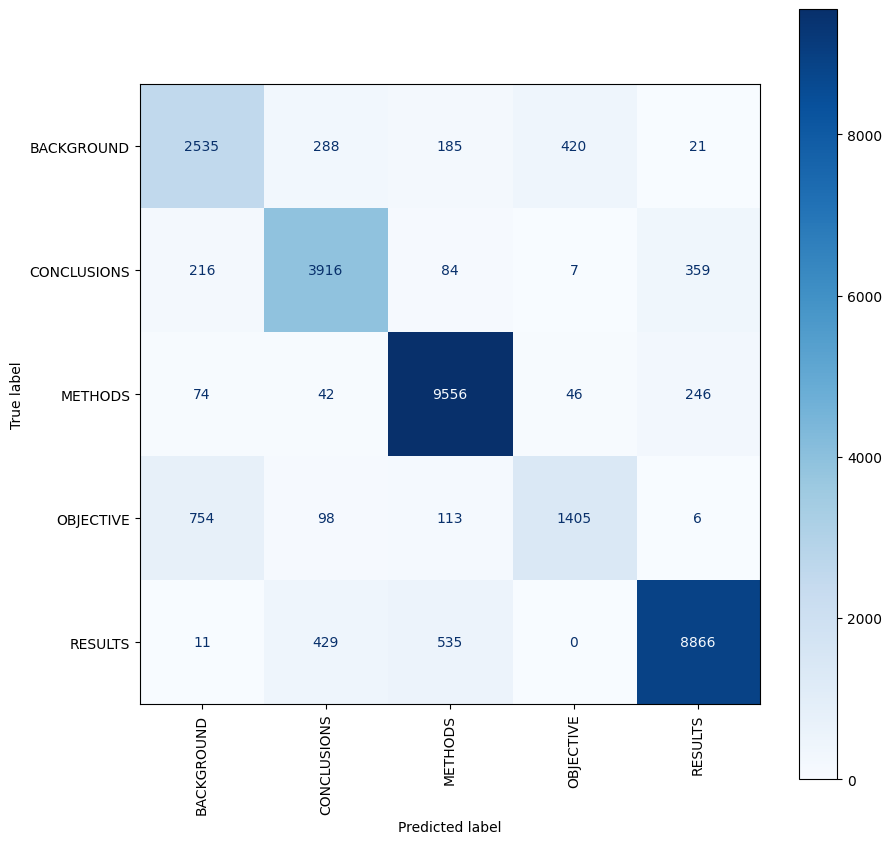

In [ ]:
plot_confusion_matrix(y_true, y_pred, class_names=class_names)

## **Model - 3 (Convolutional 1D with Character embedding)**

### Convert character level tokens

In [260]:
def split_into_char(text):
    return ' '.join(list(text))

In [261]:
split_into_char(train_df['text'].to_list()[0])

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [262]:
train_char_sentences = [split_into_char(text) for text in train_sentences]
val_char_sentences = [split_into_char(text) for text in val_sentences]
test_char_sentences = [split_into_char(text) for text in test_sentences]

In [263]:
train_char_sentences[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

### Character Vectorizer

In [264]:
char_length = [len(sentence.split()) for sentence in train_char_sentences]
char_length[:10]

[233, 111, 97, 52, 175, 119, 132, 110, 145, 44]

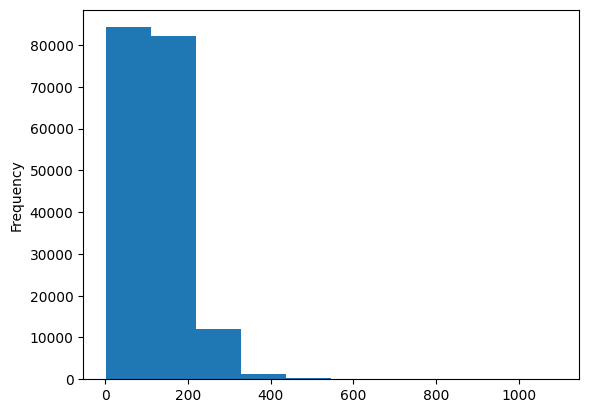

In [265]:
pd.Series(char_length).plot(kind='hist');

In [266]:
output_sequence_length = int(np.percentile(char_length, 97))
output_sequence_length

264

In [267]:
import string

characters = string.ascii_lowercase + string.digits + string.punctuation
print(characters)
vocab_size = len(characters) + 2 # 2 because 'space' and 'UNK'
vocab_size

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


70

### Character TextVectorizer

In [268]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size,
                                                    output_sequence_length=output_sequence_length,
                                                    name='Character_TextVectorizer')

char_vectorizer.adapt(train_char_sentences)

In [269]:
inverse_vocab = char_vectorizer.get_vocabulary()
vocab_size = len(inverse_vocab)
print(f'Length of the vocabulary: {vocab_size}')
print(f'Top 5 max repeated vocabulary: {inverse_vocab[:5]}')
print(f'Top 5 least repeated vocabulary: {inverse_vocab[-5:]}')

Length of the vocabulary: 28
Top 5 max repeated vocabulary: ['', '[UNK]', 'e', 't', 'i']
Top 5 least repeated vocabulary: ['k', 'x', 'z', 'q', 'j']


### Character Embedding

In [270]:
char_embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                           output_dim=16,
                                           name='Character_Embedding')

In [271]:
char_embedding(char_vectorizer(train_char_sentences[1]))

<tf.Tensor: shape=(264, 16), dtype=float32, numpy=
array([[ 0.03868195,  0.04185421,  0.03500234, ...,  0.04707446,
        -0.02143057, -0.0012998 ],
       [-0.03209932,  0.04100538, -0.02366881, ...,  0.03140319,
         0.00339801,  0.02109313],
       [-0.00273808, -0.02046462, -0.02419996, ..., -0.04464322,
        -0.0275543 , -0.00900964],
       ...,
       [ 0.00233435,  0.02875109,  0.04623128, ...,  0.00022829,
         0.04516843, -0.00219388],
       [ 0.00233435,  0.02875109,  0.04623128, ...,  0.00022829,
         0.04516843, -0.00219388],
       [ 0.00233435,  0.02875109,  0.04623128, ...,  0.00022829,
         0.04516843, -0.00219388]], dtype=float32)>

In [272]:
# Create the model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Input_layer')

vect = char_vectorizer(inputs)

embed = char_embedding(vect)

bidirectional = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embed)

maxpool = tf.keras.layers.GlobalMaxPool1D()(bidirectional)

outputs = tf.keras.layers.Dense(5, activation='softmax', name='Output_layer')(maxpool)

model_3 = tf.keras.Model(inputs, outputs, name='Model_3_Conv1D')


# Compile the model
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                metrics=['accuracy'])

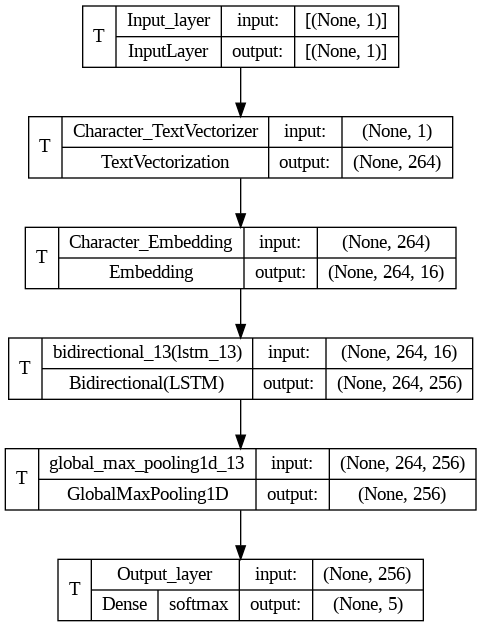

In [273]:
tf.keras.utils.plot_model(model_3, show_trainable=True, show_shapes=True, show_layer_activations=True)

In [274]:
# Create the dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char_sentences, train_target_one_hot))
train_char_dataset = train_char_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char_sentences, val_target_one_hot))
val_char_dataset = val_char_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [275]:
# Fit the model
history_3 = model_3.fit(train_char_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.15 * len(train_char_dataset)),
                        validation_data=val_char_dataset,
                        validation_steps=int(0.15 * len(val_char_dataset)))

Epoch 1/5
422/422 [==============================] - 16s 28ms/step - loss: 1.4690 - accuracy: 0.3963 - val_loss: 1.3786 - val_accuracy: 0.4853
Epoch 2/5
422/422 [==============================] - 11s 26ms/step - loss: 1.3441 - accuracy: 0.5133 - val_loss: 1.3132 - val_accuracy: 0.5342
Epoch 3/5
422/422 [==============================] - 11s 26ms/step - loss: 1.2924 - accuracy: 0.5581 - val_loss: 1.2818 - val_accuracy: 0.5810
Epoch 4/5
422/422 [==============================] - 12s 28ms/step - loss: 1.2624 - accuracy: 0.5845 - val_loss: 1.2242 - val_accuracy: 0.6161
Epoch 5/5
422/422 [==============================] - 12s 28ms/step - loss: 1.2395 - accuracy: 0.6031 - val_loss: 1.2094 - val_accuracy: 0.6257


In [276]:
# Predict the data
y_prob = model_3.predict(val_char_dataset)
y_prob

473/473 [==============================] - 5s 10ms/step


array([[0.30089077, 0.3291706 , 0.16356651, 0.12226057, 0.0841115 ],
       [0.35715258, 0.17760217, 0.08218558, 0.29321358, 0.08984617],
       [0.42938402, 0.04728055, 0.08506433, 0.38814816, 0.05012288],
       ...,
       [0.080971  , 0.08297058, 0.17559792, 0.03810696, 0.62235355],
       [0.18504505, 0.17843136, 0.2350539 , 0.16017734, 0.24129233],
       [0.2903468 , 0.27226132, 0.22742926, 0.06879999, 0.14116263]],
      dtype=float32)

In [277]:
y_pred = tf.argmax(y_prob, axis=1).numpy()
y_pred

array([1, 0, 0, ..., 4, 4, 0])

In [278]:
# Results
model_3_results = calculate_results(y_true, y_pred)
model_3_results

{'Accuracy score': 0.6214749106315371,
 'Precision score': 0.6417631237288203,
 'Recall score': 0.6214749106315371,
 'F1 score': 0.6115540971095325}

## **Model - 4 (Pretrained token embedding + Character embedding)**

In [279]:
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='Token_input_layer')

embed_1 = tf_hub_use_layer(token_inputs)

dense_1 = tf.keras.layers.Dense(128, activation='relu')(embed_1)

token_model = tf.keras.Model(token_inputs,
                             dense_1,
                             name='Token_model')



char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Char_input_layer')

vect = char_vectorizer(char_inputs)

embed_2 = char_embedding(vect)

bidirectional = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embed_2)

maxpool = tf.keras.layers.GlobalMaxPooling1D()(bidirectional)

char_model = tf.keras.Model(char_inputs,
                            maxpool,
                            name='Char_model')



concate = tf.keras.layers.Concatenate(name='Model_concatenation')([token_model.output,
                                                                   char_model.output])

drop_1 = tf.keras.layers.Dropout(0.5)(concate)

dense_2 = tf.keras.layers.Dense(128, activation='relu')(drop_1)

drop_2 = tf.keras.layers.Dropout(0.2)(dense_2)

outputs = tf.keras.layers.Dense(5, activation='softmax', name='Ouput_layer')(drop_2)



model_4 = tf.keras.Model([token_model.input, char_model.input],
                         outputs,
                         name='Model_4_Token_Char_model')


# Compile the model
model_4.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                metrics=['accuracy'])

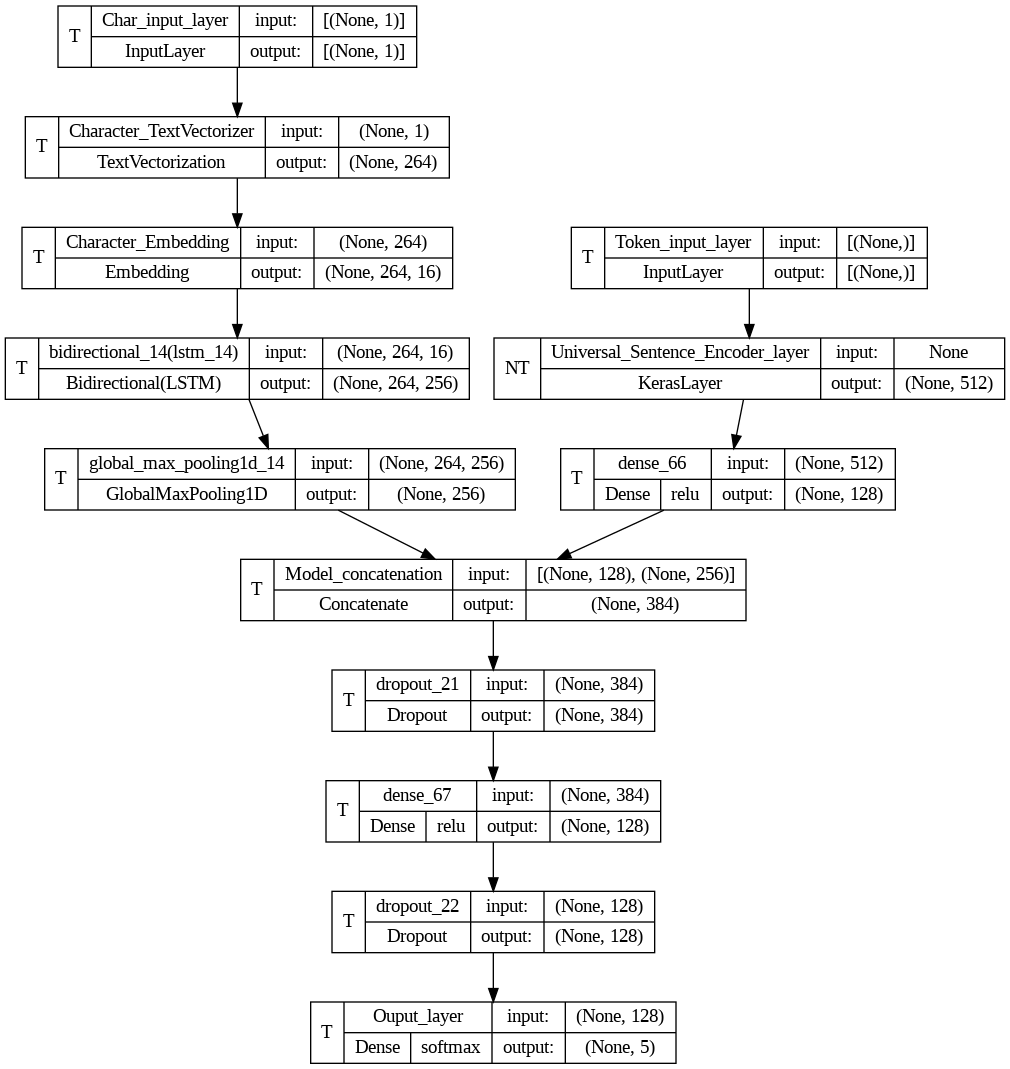

In [280]:
tf.keras.utils.plot_model(model_4, show_shapes=True, show_trainable=True, show_layer_activations=True)

In [281]:
# Create the dataset
train_token_char_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, train_char_sentences), train_target_one_hot))
train_token_char_dataset = train_token_char_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

val_token_char_dataset = tf.data.Dataset.from_tensor_slices(((val_sentences, val_char_sentences), val_target_one_hot))
val_token_char_dataset = val_token_char_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [282]:
for text, target in train_token_char_dataset.take(1):
    print(text[0].shape, text[1].shape, target.shape)

(64,) (64,) (64, 5)


In [ ]:
# Fit the model
history_4 = model_4.fit(train_token_char_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.15 * len(train_token_char_dataset)),
                        validation_data=val_token_char_dataset,
                        validation_steps=int(0.15 * len(val_token_char_dataset)))

Epoch 1/5
422/422 [==============================] - 27s 45ms/step - loss: 1.2014 - accuracy: 0.6343 - val_loss: 1.0969 - val_accuracy: 0.7129
Epoch 2/5
422/422 [==============================] - 15s 36ms/step - loss: 1.1148 - accuracy: 0.7032 - val_loss: 1.0683 - val_accuracy: 0.7350
Epoch 3/5
422/422 [==============================] - 15s 36ms/step - loss: 1.0878 - accuracy: 0.7233 - val_loss: 1.0408 - val_accuracy: 0.7489
Epoch 4/5
422/422 [==============================] - 15s 36ms/step - loss: 1.0851 - accuracy: 0.7252 - val_loss: 1.0277 - val_accuracy: 0.7547
Epoch 5/5
422/422 [==============================] - 17s 39ms/step - loss: 1.0639 - accuracy: 0.7408 - val_loss: 1.0215 - val_accuracy: 0.7641


In [ ]:
# Predict with the model
y_prob = model_4.predict(val_token_char_dataset)
y_prob[:2]

In [ ]:
y_pred = tf.argmax(y_prob, axis=1).numpy()
y_pred

In [ ]:
model_4_results = calculate_results(y_true, y_pred)
model_4_results

## **Model - 5 (Pretrained token embedding + Character embedding + Positional embedding)**

In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,0,IgE sensitization to Aspergillus fumigatus and...,9
1,1,0,It is not clear whether these patients would b...,9
2,2,3,We sought to determine whether a @-month cours...,9
3,3,2,Asthmatic patients who were IgE sensitized to ...,9
4,4,2,Primary outcomes were improvement in quality o...,9


### Create `line_number` one-hot encoding

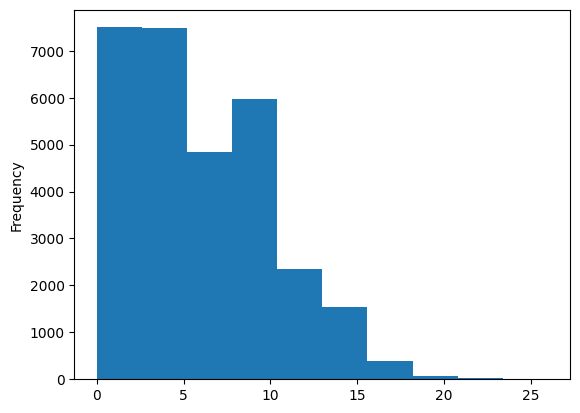

In [ ]:
# Line number distrubution
train_df['line_number'].plot(kind='hist');

In [ ]:
line_max_depth = int(np.percentile(train_df['line_number'].to_list(), 97))
line_max_depth

14

In [ ]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_list(), depth=line_max_depth)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_list(), depth=line_max_depth)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_list(), depth=line_max_depth)

train_line_number_one_hot[:5]

<tf.Tensor: shape=(5, 14), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

### Create `total_lines` one-hot encoding

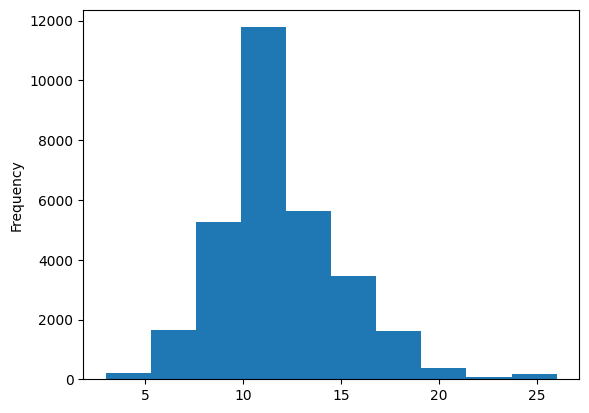

In [ ]:
train_df['total_lines'].plot(kind='hist');

In [ ]:
lines_max_depth = int(np.percentile(train_df['total_lines'].to_list(), 96))
lines_max_depth

18

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_list(), depth=lines_max_depth)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_list(), depth=lines_max_depth)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_list(), depth=lines_max_depth)

train_total_lines_one_hot[:5]

<tf.Tensor: shape=(5, 18), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)>

In [ ]:
# Pretrained token embedding model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='Token_input_layer')

tf_hub = tf_hub_use_layer(token_inputs)

dense = tf.keras.layers.Dense(128, activation='relu')(tf_hub)

token_model = tf.keras.Model(token_inputs,
                             dense,
                             name='Token_model')



# Character embedding model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input_layer')

vectorize = char_vectorizer(char_inputs)

embed = char_embedding(vectorize)

bidirectional = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(embed)

char_model = tf.keras.Model(char_inputs,
                            bidirectional,
                            name='Character_model')



# Concate Token embedding and Character embedding models
token_char_combine = tf.keras.layers.Concatenate(name='Token_Character_hybrid_layer')([token_model.output, char_model.output])

dense_1 = tf.keras.layers.Dense(128, activation='relu')(token_char_combine)

drop = tf.keras.layers.Dropout(0.5)(dense_1)



# Line number model
line_inputs = tf.keras.layers.Input(shape=(14,), dtype=tf.float32, name='Line_number_input_layer')

dense_2 = tf.keras.layers.Dense(32, activation='relu')(line_inputs)

line_number_model = tf.keras.Model(line_inputs,
                                   dense_2,
                                   name='Line_number_model')



# Total lines model
lines_inputs = tf.keras.layers.Input(shape=(18,), dtype=tf.float32, name='Total_lines_input_layer')

dense_3 = tf.keras.layers.Dense(32, activation='relu')(lines_inputs)

total_lines_model = tf.keras.Model(lines_inputs,
                                   dense_3,
                                   name='Total_lines_model')



# Concate all the layers (Tribrid Model)
tribrid_line_lines_token_char_model = tf.keras.layers.Concatenate(name='Tribrid_line_lines_token_char_layer')([line_number_model.output,
                                                                                                               total_lines_model.output,
                                                                                                               drop])

outputs = tf.keras.layers.Dense(5, activation='relu')(tribrid_line_lines_token_char_model)


model_5 = tf.keras.Model([line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
                         outputs,
                         name='Model_5_tribrid_model')



# Compile the model
model_5.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                metrics=['accuracy'])

In [ ]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="token_inputs")

token_embeddings = tf_hub_use_layer(token_inputs)

token_outputs = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)


# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1, ), dtype="string", name="char_inputs")

char_vectors = char_vectorizer(char_inputs)

char_embeddings = char_embedding(char_vectors)

char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)


# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = tf.keras.layers.Input(shape=(14,), dtype=tf.float32, name="line_number_input")
# dense layer with 32 units & relu activation
x = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)


# 4. Total lines model
total_lines_inputs = tf.keras.layers.Input(shape=(18,), dtype=tf.float32, name="total_lines_input")
y = tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)


# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])
z = tf.keras.layers.Dense(256, activation="relu")(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)


# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = tf.keras.layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output, total_lines_model.output, z])


# 7. Create output layer
output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)


# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")



# Compile the model
model_5.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                metrics=['accuracy'])

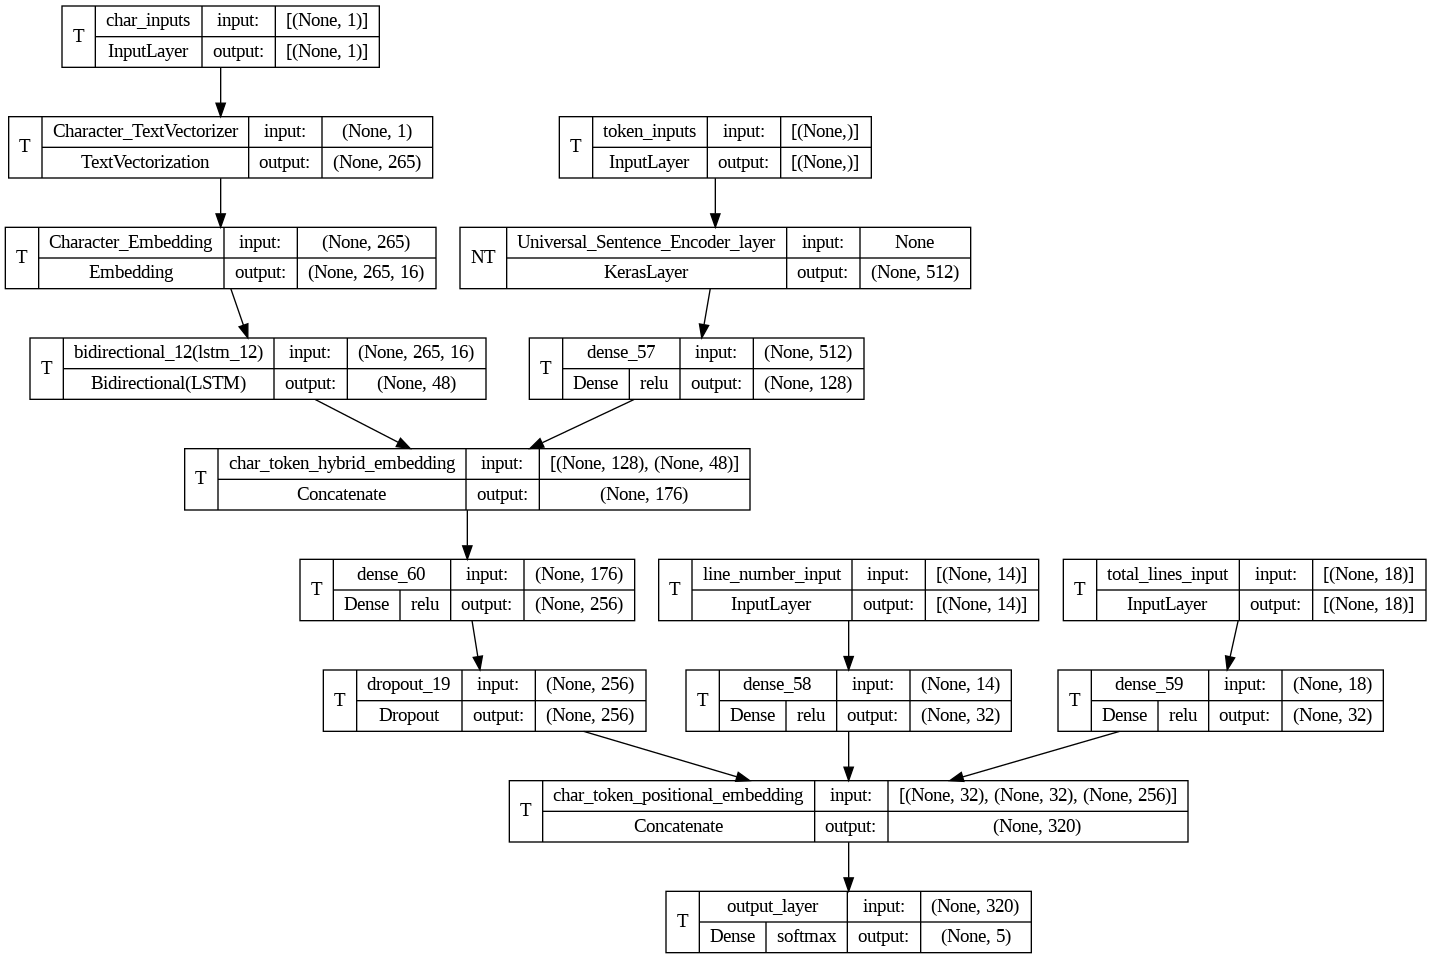

In [ ]:
tf.keras.utils.plot_model(model_5, show_shapes=True, show_trainable=True, show_layer_activations=True)

In [ ]:
# Create the dataset
train_line_lines_token_char_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, train_total_lines_one_hot, train_sentences, train_char_sentences))
train_line_lines_token_char_label = tf.data.Dataset.from_tensor_slices((train_target_one_hot))
train_line_lines_token_char_dataset = tf.data.Dataset.zip(train_line_lines_token_char_data,
                                                          train_line_lines_token_char_label)
train_line_lines_token_char_dataset = train_line_lines_token_char_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

val_line_lines_token_char_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, val_total_lines_one_hot, val_sentences, val_char_sentences))
val_line_lines_token_char_label = tf.data.Dataset.from_tensor_slices((val_target_one_hot))
val_line_lines_token_char_dataset = tf.data.Dataset.zip(val_line_lines_token_char_data,
                                                          val_line_lines_token_char_label)
val_line_lines_token_char_dataset = val_line_lines_token_char_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_line_lines_token_char_dataset, val_line_lines_token_char_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

In [ ]:
# Fit the model
history_5 = model_5.fit(train_line_lines_token_char_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.15 * len(train_line_lines_token_char_dataset)),
                        validation_data=val_line_lines_token_char_dataset,
                        validation_steps=int(0.15 * len(val_line_lines_token_char_dataset)))

Epoch 1/5
70/70 [==============================] - 12s 84ms/step - loss: nan - accuracy: 0.1158 - val_loss: nan - val_accuracy: 0.1187
Epoch 2/5
70/70 [==============================] - 5s 67ms/step - loss: nan - accuracy: 0.1083 - val_loss: nan - val_accuracy: 0.1187
Epoch 3/5
70/70 [==============================] - 3s 48ms/step - loss: nan - accuracy: 0.1136 - val_loss: nan - val_accuracy: 0.1187
Epoch 4/5
70/70 [==============================] - 3s 48ms/step - loss: nan - accuracy: 0.1187 - val_loss: nan - val_accuracy: 0.1187
Epoch 5/5
70/70 [==============================] - 5s 66ms/step - loss: nan - accuracy: 0.1112 - val_loss: nan - val_accuracy: 0.1187


In [ ]:
# Predict the outputs with the model
y_prob = model_5.predict(val_line_lines_token_char_dataset)
y_prob[:2]

471/471 [==============================] - 12s 23ms/step


array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32)

In [ ]:
y_pred = tf.argmax(y_prob, axis=1).numpy()
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Calculate the results
model_5_results = calculate_results(y_true, y_pred)
model_5_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy score': 0.12015928322548532,
 'Precision score': 0.014438253345262397,
 'Recall score': 0.12015928322548532,
 'F1 score': 0.025778929053174682}

## **Compare all the results**

In [ ]:
overall_results = pd.DataFrame({
    'Baseline Model Tfidf': base_model_results,
    'Model 1 Token embedding': model_1_results,
    'Model 2 USE Token embedding': model_2_results,
    'Pubmed Bert embedding': pubmed_bert_results,
    'Model 3 Character embedding': model_3_results,
    'Model 4 Pretrained Token + Character embedding': model_4_results,
    'Model 5 Line number + Total lines + Pretrained Token + Character embedding': model_5_results,
})


overall_results = overall_results.T
overall_results

,Accuracy score,Precision score,Recall score,F1 score
Baseline Model Tfidf,0.675593,0.670735,0.675593,0.633786
Model 1 Token embedding,0.774415,0.769589,0.774415,0.771269
Model 2 USE Token embedding,0.698756,0.691256,0.698756,0.691429
Pubmed Bert embedding,0.832753,0.852819,0.832753,0.825642
Model 3 Character embedding,0.530612,0.575513,0.530612,0.498763
Model 4 Pretrained Token + Character embedding,0.700548,0.695312,0.700548,0.688030
Model 5 Line number + Total lines + Pretrained Token + Character embedding,0.120159,0.014438,0.120159,0.025779


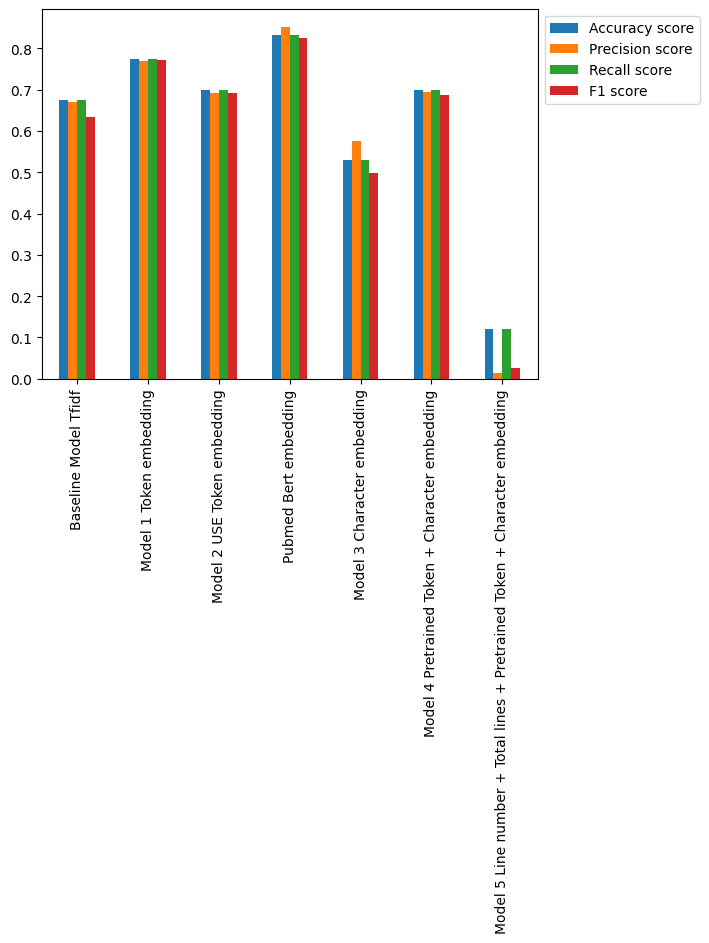

In [ ]:
overall_results.plot(kind='bar').legend(bbox_to_anchor=[1.0, 1.0]);

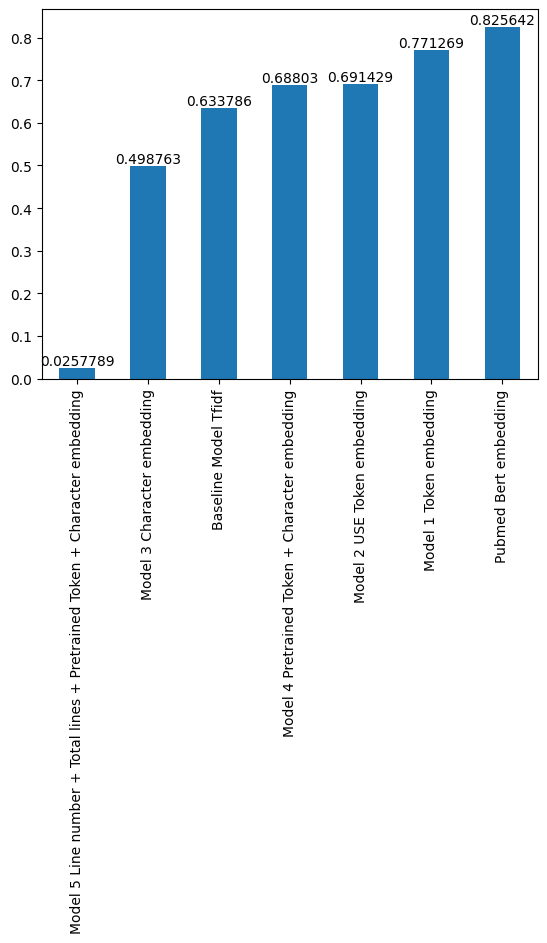

In [ ]:
fig, ax = plt.subplots()
overall_results['F1 score'].sort_values().plot(kind='bar')
ax.bar_label(ax.containers[0]);

### Full data

In [ ]:
all_data_dir = '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
os.listdir(all_data_dir)

['.ipynb_checkpoints', 'test.txt', 'dev.txt', 'train.txt']

In [ ]:
import zipfile

data = zipfile.ZipFile('/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip')
data.extractall()
data.close()

In [ ]:
files = tuple([all_data_dir + filename for filename in os.listdir(all_data_dir)[1:]])
files

('/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt')

In [ ]:
test_file, val_file, train_file = files

val_file, train_file, test_file

('/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt')

In [ ]:
train_data_dict = abstract_txt_file_of_sentences_to_dict(train_file)
val_data_dict = abstract_txt_file_of_sentences_to_dict(val_file)
test_data_dict = abstract_txt_file_of_sentences_to_dict(test_file)

In [ ]:
train_data_dict[:5], len(train_data_dict)

([{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
   'total_lines': 10},
  {'line_number': 1,
   'target': 'BACKGROUND',
   'text': 'This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .',
   'total_lines': 10},
  {'line_number': 2,
   'target': 'METHODS',
   'text': 'This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .',
   'total_lines': 10},
  {'line_number': 3,
   'target': 'METHODS',
   'text': "The intervention group will participate in the online group program ` Positive Outlook ' .",
   'total_lines': 10},
  {'line_n

In [ ]:
val_data_dict[:5], len(val_data_dict)

([{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Adrenergic activation is thought to be an important determinant of outcome in subjects with chronic heart failure ( CHF ) , but baseline or serial changes in adrenergic activity have not been previously investigated in a large patient sample treated with a powerful antiadrenergic agent .',
   'total_lines': 8},
  {'line_number': 1,
   'target': 'RESULTS',
   'text': 'Systemic venous norepinephrine was measured at baseline , @ months , and @ months in the beta-Blocker Evaluation of Survival Trial ( BEST ) , which compared placebo treatment with the beta-blocker/sympatholytic agent bucindolol .',
   'total_lines': 8},
  {'line_number': 2,
   'target': 'RESULTS',
   'text': 'Baseline norepinephrine level was associated with a progressive increase in rates of death or death plus CHF hospitalization that was independent of treatment group .',
   'total_lines': 8},
  {'line_number': 3,
   'target': 'RESULTS',
   'text': 'On multivar

In [ ]:
test_data_dict[:5], len(test_data_dict)

([{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Many pathogenic processes and diseases are the result of an erroneous activation of the complement cascade and a number of inhibitors of complement have thus been examined for anti-inflammatory actions .',
   'total_lines': 10},
  {'line_number': 1,
   'target': 'BACKGROUND',
   'text': 'It was recently demonstrated that supraphysiological concentrations of the endogenous complement inhibitor MAp@ ( also denoted MAP@ ) protect against myocardial reperfusion injury .',
   'total_lines': 10},
  {'line_number': 2,
   'target': 'BACKGROUND',
   'text': 'In the present study , we examined the association between outcome after acute myocardial infarction ( MI ) and the plasma levels of MAp@ and its related proteins MASP-@ and MASP-@ in patients with first-time MI .',
   'total_lines': 10},
  {'line_number': 3,
   'target': 'BACKGROUND',
   'text': 'In addition , we compared plasma levels of MAp@ , MASP-@ , and MASP-@ in MI patients 

In [ ]:
# Pubmed model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='Input_layer')

preprocess = preprocessing_layer(inputs)

bert = bert_layer(preprocess)['sequence_output']

dense = tf.keras.layers.Dense(256, activation='relu')(bert)

maxpool = tf.keras.layers.GlobalMaxPooling1D()(dense)

outputs = tf.keras.layers.Dense(5, activation='softmax')(maxpool)

pubmed_model = tf.keras.Model(inputs, outputs, name='Pubmed_model')


# Compile the model
pubmed_model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                     metrics=['accuracy'])

# 📖 09. Milestone Project 2: SkimLit 📄🔥 Extra-curriculum

* For more on working with text/spaCy, see [spaCy's advanced NLP course](https://course.spacy.io/en/). If you're going to be working on production-level NLP problems, you'll probably end up using spaCy.
* For another look at how to approach a text classification problem like the one we've just gone through, I'd suggest going through [Google's Machine Learning Course for text classification](https://developers.google.com/machine-learning/guides/text-classification).
* Since our dataset has imbalanced classes (as with many real-world datasets), so it might be worth looking into the [TensorFlow guide for different methods to training a model with imbalanced classes](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
